In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_relative_footsteps_continuous
%store -r Y_relative_footsteps_continuous
print(X_relative_footsteps_continuous.shape)
print(Y_relative_footsteps_continuous.shape)

(10027, 28)
(10027, 8)


# Multivariate Linear Regression (Foot prediction)

In [6]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [7]:
X_relative_footsteps_continuous[0, :]

array([ 0.1       ,  0.        ,  0.        ,  0.06422444,  0.12709958,
        0.02129842,  0.03284169,  0.00745874, -0.01805852,  0.23490033,
        0.18683081, -0.40515856,  0.23261811, -0.20303247, -0.40508065,
       -0.26129142,  0.13343325, -0.40023591, -0.24991612, -0.15232612,
       -0.40053536,  0.        ,  1.        ,  1.        ,  0.        ,
        0.1       ,  0.        ,  0.        ])

In [8]:
# Entries where FL is swinging
idxs = np.where(X_relative_footsteps_continuous[:, 21] == 1)[0]
X_relative_footsteps_continuous_FL_swinging = X_relative_footsteps_continuous[idxs]
Y_relative_footsteps_continuous_FL_swinging = Y_relative_footsteps_continuous[idxs]

## Predict FL foot -> x

In [9]:
X_relative_footsteps_continuous_FL_swinging.shape

(5005, 28)

In [10]:
X_relative_footsteps_continuous_FL_swinging[0, :]

array([ 1.00000001e-01,  0.00000000e+00,  0.00000000e+00,  9.11893692e-02,
       -1.77642498e-01, -1.44425490e-03, -3.79832882e-04,  2.90665488e-02,
        2.75820694e-03,  2.19544484e-01,  2.08664947e-01, -4.04755931e-01,
        2.41754690e-01, -1.84191521e-01, -4.05253866e-01, -2.43501147e-01,
        1.54919233e-01, -4.00495847e-01, -2.74535236e-01, -1.27386125e-01,
       -4.00794023e-01,  1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.00000000e+00,  1.00000001e-01,  0.00000000e+00,  0.00000000e+00])

In [11]:
Y_relative_footsteps_continuous_FL_swinging[0, :]

array([ 0.23613742,  0.18750784,  0.23240836, -0.20432631, -0.26976698,
        0.12960223, -0.24904521, -0.15161172])

### Linear Regression

In [13]:
# Input
X = np.hstack((X_relative_footsteps_continuous_FL_swinging[:, :3], # motion command
               X_relative_footsteps_continuous_FL_swinging[:, 9:11], # FL (x,y) position
               X_relative_footsteps_continuous_FL_swinging[:, 12:14], # FR (x,y) position
               X_relative_footsteps_continuous_FL_swinging[:, 15:17], # RL (x,y) position
               X_relative_footsteps_continuous_FL_swinging[:, 18:20])) # RR (x,y) position 

# Target
Y = np.array([Y_relative_footsteps_continuous_FL_swinging[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True)

# Create the model
model_fl_relative_support_x = LinearRegression()

# Fit the model
model_fl_relative_support_x.fit(X_train, Y_train)

# Predict
predictions = model_fl_relative_support_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9986118599813262
RMSE:  0.0011493433433455865
The lowest error is:  6.116961178970204e-07
The highest error is:  0.015268415156838022
The avg. error is:  0.000676180210139038


In [14]:
model_fl_relative_support_x.coef_

array([[ 0.12405419, -0.00814678,  0.01036141,  0.46618838,  0.01156951,
         0.02480616,  0.0638548 , -0.08431654,  0.04055149, -0.0558645 ,
        -0.01480057]])

In [15]:
model_fl_relative_support_x.intercept_

array([0.08057133])

Text(0, 0.5, 'Predictions')

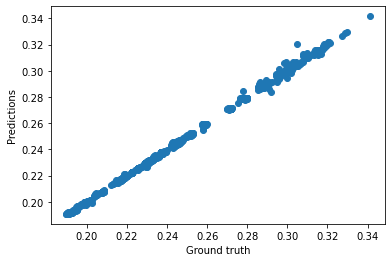

In [16]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [17]:
#%store model_fl_relative_support_x

In [18]:
#for idx, prediction in enumerate(predictions):
#    print(f'Start: {X_test[idx, 6]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [19]:
# Save model
#joblib.dump(model_fl_relative_support_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_fl_relative_support_x.sav")

### Predict FL foot -> y

In [23]:
# Input
X = np.hstack((X_relative_footsteps_continuous_FL_swinging[:, :3], # motion command
               X_relative_footsteps_continuous_FL_swinging[:, 9:11], # FL (x,y) position
               X_relative_footsteps_continuous_FL_swinging[:, 12:14], # FR (x,y) position
               X_relative_footsteps_continuous_FL_swinging[:, 15:17], # RL (x,y) position
               X_relative_footsteps_continuous_FL_swinging[:, 18:20])) # RR (x,y) position 

# Target
Y = np.array([Y_relative_footsteps_continuous_FL_swinging[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True)

# Create the model
model_fl_relative_support_y = LinearRegression()

# Fit the model
model_fl_relative_support_y.fit(X_train, Y_train)

# Predict
predictions = model_fl_relative_support_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9975911638582261
RMSE:  0.001039983246818197
The lowest error is:  1.4108117987188251e-06
The highest error is:  0.013777987222921007
The avg. error is:  0.0006488300954468585


In [24]:
model_fl_relative_support_y.coef_

array([[-0.00241718,  0.11840397,  0.01379421,  0.02871768,  0.5210759 ,
        -0.04024635, -0.06530582,  0.08665785, -0.00794945, -0.01373164,
        -0.08494682]])

In [25]:
model_fl_relative_support_y.intercept_

array([0.07771529])

Text(0, 0.5, 'Predictions')

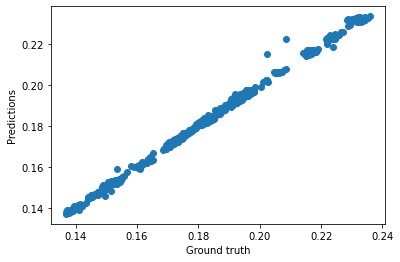

In [26]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [31]:
#%store model_fl_relative_support_y

In [32]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [25]:
# Save model
#joblib.dump(model_fl_relative_support_y, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_fl_relative_support_y.sav")